In [1]:
from ROOT import TFile, TH1D
from Plotter.PlotterTools.ObsAndExp import ObsAndExp
import numpy as np

Welcome to JupyROOT 6.24/00


In [2]:
PROMPTs = ['rare', 'ttX', 'VV']
histkey = "muons/1/pt"
SYSTs = ["Central", "FakeUp", "FakeDown", "ElectronEnUp", "ElectronEnDown", "ElectronResUp", "ElectronResDown", "MuonEnUp", "MuonEnDown", "JetEnUp", "JetEnDown", "JetResUp", "JetResDown", "L1PrefireUp", "L1PrefireDown", "PUReweightUp", "PUReweightDown"]

In [3]:
def get_hist(sample, histkey, meas, channel, syst="Central"):
    if sample == "fake":
        f = TFile.Open(f"Outputs/{meas}/{channel}/DATA.root")
    else:
        f = TFile.Open(f"Outputs/{meas}/{channel}/{sample}.root")
    h = f.Get(f"{sample}/{syst}/{histkey}")
    h.SetDirectory(0)

    return h

In [9]:
def get_sf(meas, channel, syst="Central"):
    histkey = "ZMass"

    # get data hist
    h_data = TH1D()
    if syst in ["Central", "ElectronEnUp", "ElectronEnDown", "ElectronResUp", "ElectronResDown", "MuonEnUp", "MuonEnDown", "JetEnUp", "JetEnDown", "JetResUp", "JetResDown"]:
        h_data = get_hist("DATA", histkey, meas, channel, syst)
    else:
        h_data = get_hist("DATA", histkey, meas, channel)
    evts_data = h_data.Integral()

    evts_bkg = 0.

    # get fake hist
    h_fake = TH1D()
    if syst == "FakeUp":
        h_fake = get_hist("fake", histkey, meas, channel, syst="Up")
    elif syst == "FakeDown":
        h_fake = get_hist("fake", histkey, meas, channel, syst="Down")
    else:
        h_fake = get_hist("fake", histkey, meas, channel)
    evts_bkg += h_fake.Integral()

    # get mc
    for mc in PROMPTs:
        h = TH1D()
        if syst in ["Central", "FakeUp", "FakeDown"]:
            h = get_hist(mc, histkey, meas, channel)
        else:
            h = get_hist(mc, histkey, meas, channel, syst)
        evts_bkg += h.Integral()

    # conv
    h_conv = TH1D()
    if syst in ["Central", "FakeUp", "FakeDown"]:
        h_conv = get_hist(meas, histkey, meas, channel)
    else:
        h_conv = get_hist(meas, histkey, meas, channel, syst)
    
    sf = (evts_data - evts_bkg) / h_conv.Integral()
    
    return sf



In [10]:
total_err = 0.
sf_central = get_sf("DY", "1E2Mu", "Central")
print(sf_central)
for syst in SYSTs:
    #print(f"{syst}: {get_sf("DY", "1E2Mu", syst)}")
    sf = get_sf("DY", "1E2Mu", syst)
    total_err += np.power(sf_central - sf, 2)
total_err = np.sqrt(total_err)
print(f"total err: {total_err}")

1.1190094708068306
total err: 0.5633136484442929


In [100]:
# get data
h_data = get_hist("DATA", histkey)

# estimate systematics for fake
h_fakes = dict()
h_fakes["Central"] = get_hist("fake", histkey, syst="Central")
h_fakes["Up"] = get_hist("fake", histkey, syst="Up")
h_fakes["Down"] = get_hist("fake", histkey, syst="Down")

h_fake = h_fakes["Central"].Clone("h_fake")
h_fake.SetDirectory(0)
#bins = h_fake.GetMaximumBin()
bins = h_fake.GetNbinsX()
for bin in range(bins+1):
    center = h_fake.GetBinContent(bin)
    upper = h_fakes["Up"].GetBinContent(bin) - center
    lower = center - h_fakes["Down"].GetBinContent(bin)
    gm = pow(pow(upper, 2) + pow(lower, 2), 0.5)
    h_fake.SetBinError(bin, gm)

hists = dict()
hists['fake'] = get_hist("fake", histkey, syst="Central")

for mc in PROMPTs + ["DY"]:
    h = get_hist(mc, histkey, syst)
    h.SetDirectory(0)
    hists[mc] = h

In [102]:
# set conv error
h = hists['DY'].Clone("temp")
hists['DY'].Scale(sf_central)
bins = h.GetNbinsX()
for bin in range(bins+1):
    center = h.GetBinContent(bin) * sf_central
    upper = h.GetBinContent(bin)*(sf_central + total_err) - center
    lower = center - h.GetBinContent(bin)*(sf_central - total_err)
    err = np.sqrt(np.power(upper, 2) + np.power(lower, 2))
    hists['DY'].SetBinError(bin, err)

In [103]:
cvs_params = {
    "logy": False,
    "grid": False
}
info_params = {
    "info": "L_{int} = 41.9 fb^{-1}",
    "cms_text": "CMS",
    "extra_text": "Work in progress"
}
hist_params = {
    "x_title": "P_{T}(e)",
    "x_range": [0, 120],
    "y_title": "Events",
    "rebin": 5,
    "ratio_range": [0., 2.0]
}

INFO: Storing histograms...
INFO: y axis range set to be maximum of data plot
Warning in <TCanvas::Constructor>: Deleting canvas with same name: cvs


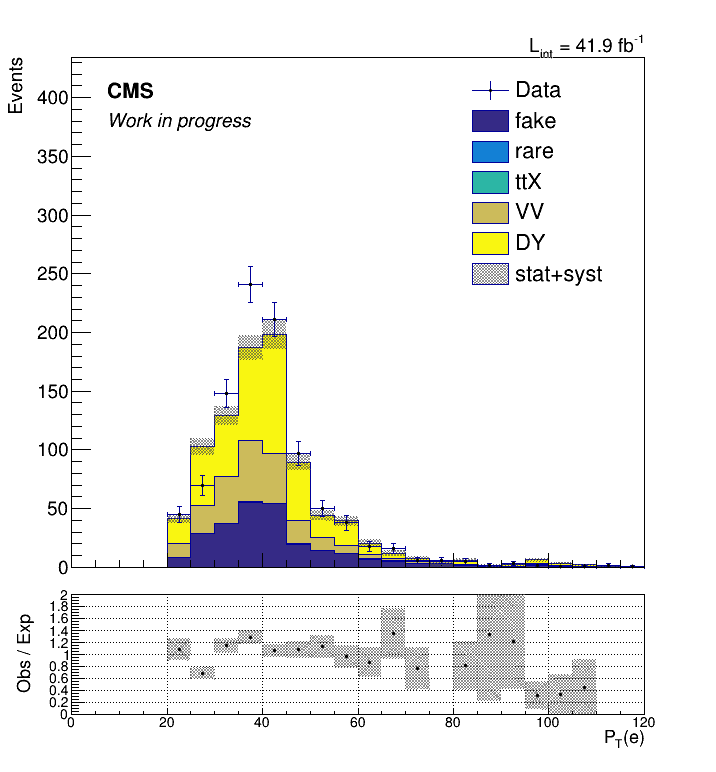

In [104]:
plotter = ObsAndExp(cvs_params, hist_params, info_params)
plotter.get_hists(h_data, hists)
plotter.combine()
plotter.draw()